


Hi! this is my code for my CS 4824 final project for Fall 2024. First we have imports :))



In [4]:
!pip install pandas numpy scikit-learn surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357290 sha256=341fd57ab9708ccc723ca8d39d3d1e6d408084ff0441d9e94086dd63034ea0d7
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split





In [6]:
# Mount Google Drive for accessing datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Define the path to the dataset
data_path = '/content/drive/MyDrive/Colab Notebooks/CS4824Project/animelist.csv'

# My data can be found at this kaggle dataset:
# https://www.kaggle.com/code/chaitanya99/recommendation-system-cf-anime/input

# Load the dataset using pandas, selecting relevant columns for analysis
rating_df = pd.read_csv(data_path, low_memory=False, usecols=["user_id", "anime_id", "rating"])

# Filter users who have rated at least 400 anime
n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()
print(f"Number of ratings after filtering users with >= 400 ratings: {len(rating_df)}")

# Scale ratings to be between 0 and 1
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

# Compute and display the average rating
avg_rating = np.mean(rating_df['rating'])
print(f"Average scaled rating: {avg_rating}")

# Identify and remove duplicate rows in the dataset
duplicates = rating_df.duplicated()
if duplicates.sum() > 0:
    print(f"> Found {duplicates.sum()} duplicate rows. Removing duplicates...")
    rating_df = rating_df[~duplicates]

# Verify that no duplicates remain
print(f"> Remaining duplicate rows after removal: {rating_df.duplicated().sum()}")

# Identify top 20 users with the most ratings
g = rating_df.groupby('user_id')['rating'].count()
top_users = g.dropna().sort_values(ascending=False)[:20]

# Identify top 20 anime with the most ratings
g = rating_df.groupby('anime_id')['rating'].count()
top_animes = g.dropna().sort_values(ascending=False)[:20]

# Join the dataset to focus on top users and anime
top_r = rating_df.join(top_users, rsuffix='_r', how='inner', on='user_id')
top_r = top_r.join(top_animes, rsuffix='_r', how='inner', on='anime_id')

# Create a pivot table to visualize user-anime interactions
user_anime_matrix = pd.crosstab(top_r['user_id'], top_r['anime_id'], top_r['rating'], aggfunc=np.sum)
print("User-Anime matrix created for top users and anime.")

# Uncomment and use the following lines for debugging or additional dataset exploration
print(user_anime_matrix.head())

Number of ratings after filtering users with >= 400 ratings: 71418114
Average scaled rating: 0.4047793589172634
> Found 1 duplicate rows. Removing duplicates...
> Remaining duplicate rows after removal: 0
User-Anime matrix created for top users and anime.
anime_id  226    1535   1575   2001   2167   4224   5081   5114   6547   \
user_id                                                                   
20807       1.0    1.0    1.0    1.0    0.8    1.0    0.9    1.0    1.0   
50485       0.0    0.6    1.0    1.0    0.9    1.0    1.0    1.0    1.0   
63900       0.7    0.0    0.0    0.0    0.0    0.0    0.0    0.9    0.0   
68042       0.8    1.0    0.9    1.0    0.7    0.9    1.0    0.9    0.7   
85472       0.7    0.0    0.0    1.0    0.9    0.9    0.0    0.0    1.0   

anime_id  6746   9253   9989   10620  11757  15809  16498  19815  20507  \
user_id                                                                   
20807       1.0    1.0    0.9    1.0    1.0    0.8    1.0    1.0    

<ipython-input-8-af41bf162be4>:43: FutureWarning: The provided callable <function sum at 0x7f73cd1be560> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  user_anime_matrix = pd.crosstab(top_r['user_id'], top_r['anime_id'], top_r['rating'], aggfunc=np.sum)


In [9]:
# Encode user and anime IDs for model input
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

print(f"Num of users: {n_users}, Num of anime: {n_animes}")
print(f"Min rating: {min(rating_df['rating'])}, Max rating: {max(rating_df['rating'])}")

# Shuffle the dataset to randomize input
rating_df = rating_df.sample(frac=1, random_state=73)

# Prepare feature and target arrays for training and testing
X = rating_df[['user', 'anime']].values
y = rating_df["rating"]

# Split dataset into training and test sets
test_set_size = 10000  # Define size of the test set
train_indices = rating_df.shape[0] - test_set_size

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print(f"> Train set ratings: {len(y_train)}")
print(f"> Test set ratings: {len(y_test)}")

# Prepare arrays for model input
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]




Num of users: 91641, Num of anime: 17560
Min rating: 0.0, Max rating: 1.0
> Train set ratings: 71408113
> Test set ratings: 10000


In [10]:
# Check accelerator setup for TensorFlow
import tensorflow as tf

TPU_INIT = True

if TPU_INIT:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
    !nvidia-smi

print(f"TensorFlow version: {tf.__version__}")



TensorFlow version: 2.15.0


In [11]:
# Import necessary TensorFlow modules
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [12]:
from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

def RecommenderNet():
    embedding_size = 128

    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = n_users,
                       output_dim = embedding_size)(user)

    anime = Input(name = 'anime', shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding',
                       input_dim = n_animes,
                       output_dim = embedding_size)(anime)

    #x = Concatenate()([user_embedding, anime_embedding])
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = RecommenderNet()
else:
    model = RecommenderNet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 anime (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 128)               1173004   ['user[0][0]']                
                                                          8                                       
                                                                                                  
 anime_embedding (Embedding  (None, 1, 128)               2247680   ['anime[0][0]']           

In [13]:
# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

start_lr = 0.0003
min_lr = 0.0001
max_lr = 0.001
batch_size = 10000

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor='val_loss',
                               mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping,
]

In [14]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
893/893 [==============================] - 44s 35ms/step - loss: 0.8039 - mae: 0.3848 - mse: 0.2001 - val_loss: 0.7999 - val_mae: 0.3847 - val_mse: 0.1998 - lr: 5.0000e-06
Epoch 2/20
893/893 [==============================] - 26s 30ms/step - loss: 0.7994 - mae: 0.3837 - mse: 0.1985 - val_loss: 0.7941 - val_mae: 0.3835 - val_mse: 0.1978 - lr: 2.0000e-05
Epoch 3/20
893/893 [==============================] - 26s 29ms/step - loss: 0.7856 - mae: 0.3792 - mse: 0.1932 - val_loss: 0.7769 - val_mae: 0.3775 - val_mse: 0.1911 - lr: 3.5000e-05
Epoch 4/20
893/893 [==============================] - 26s 29ms/step - loss: 0.7205 - mae: 0.3493 - mse: 0.1661 - val_loss: 0.6679 - val_mae: 0.3220 - val_mse: 0.1451 - lr: 5.0000e-05
Epoch 5/20
893/893 [==============================] - 26s 29ms/step - loss: 0.6103 - mae: 0.2907 - mse: 0.1188 - val_loss: 0.5977 - val_mae: 0.2844 - val_mse: 0.1152 - lr: 6.5000e-05
Epoch 6/20
893/893 [==============================] - 26s 29ms/step - loss: 0.5733 - 

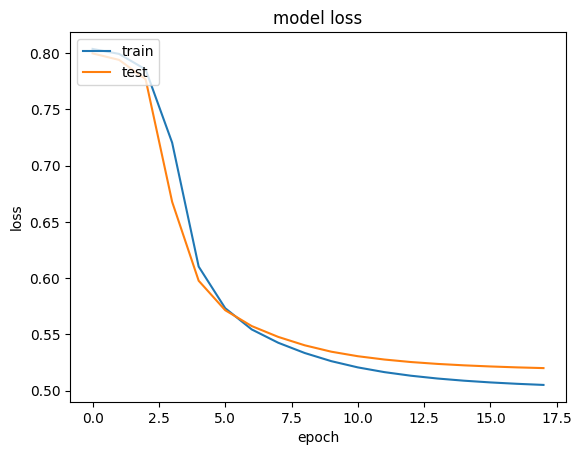

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [16]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

In [17]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS4824Project/animelist.csv', low_memory=True)
df = df.replace("Unknown", np.nan)